In [ ]:
# import core libraries
import sys
import os
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import random as rn
import matplotlib.pyplot as plt
%matplotlib inline

%tensorflow_version 2.x
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TensorFlow version: 2.8.2


In [ ]:
pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 36.8 MB 190 kB/s 


In [ ]:
# load Keras libraries
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import Sequence

In [ ]:
# enable GPU processing
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

SystemError: ignored

In [ ]:
# set random seed
seed = 777
np.random.seed(seed)
rn.seed(seed)
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [ ]:
# load the model
model_file = '/content/QED Run 1 - 99.86 Test Acc.h5'
model = load_model(model_file)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 45)]    0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 256),        309248      ['input_3[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                                  
 concatenate_1 (Concatenate)    (None, 512)          0           ['lstm_2[0][1]',                 
                                                                  'lstm_2[0][2]']           

In [ ]:
# create data load functions
def load_data(data):
    with open(data, 'r') as f:
        smiles = [r.rstrip() for r in f]
    return np.array(smiles)

def load_dictionaries(input_dict):
    with open(input_dict, 'r') as fp:
        new_dict = json.load(fp)
    return new_dict

In [ ]:
# load transfer learning dataset
smifile = '/content/nextgen_smiles.smi.txt'
data = load_data(smifile)
print("Training dataset shape:", data.shape)
print("Sample training smile: \n", data[2])

Training dataset shape: (100,)
Sample training smile: 
 NC1CC(O)C23CCC1C2Cc1c2cc[n+](nc(cnc1C=O)C3)CC1=CC=C(C=C2)N(N)O1


In [ ]:
# load the Python dictionaries that map characters-to-integers and integers-to-characters
d1 = '/content/char_to_int (1).json'
d2 = '/content/int_to_char (1).json'
char_to_int = load_dictionaries(d1)
int_to_char = load_dictionaries(d2)
n_vocab = len(char_to_int)
print("Character set vocabulary length:", n_vocab)
print("Dictionary mapping characters-to-integers:\n", char_to_int)
print("Dictionary mapping integers-to-characters:\n", int_to_char)

Character set vocabulary length: 45
Dictionary mapping characters-to-integers:
 {'!': 0, '#': 1, '(': 2, ')': 3, '+': 4, '-': 5, '.': 6, '/': 7, '1': 8, '2': 9, '3': 10, '4': 11, '5': 12, '6': 13, '7': 14, '8': 15, '=': 16, '@': 17, 'A': 18, 'B': 19, 'C': 20, 'E': 21, 'F': 22, 'H': 23, 'I': 24, 'K': 25, 'L': 26, 'M': 27, 'N': 28, 'O': 29, 'P': 30, 'S': 31, 'Z': 32, '[': 33, '\\': 34, ']': 35, 'a': 36, 'c': 37, 'g': 38, 'i': 39, 'l': 40, 'n': 41, 'o': 42, 'r': 43, 's': 44}
Dictionary mapping integers-to-characters:
 {'0': '!', '1': '#', '2': '(', '3': ')', '4': '+', '5': '-', '6': '.', '7': '/', '8': '1', '9': '2', '10': '3', '11': '4', '12': '5', '13': '6', '14': '7', '15': '8', '16': '=', '17': '@', '18': 'A', '19': 'B', '20': 'C', '21': 'E', '22': 'F', '23': 'H', '24': 'I', '25': 'K', '26': 'L', '27': 'M', '28': 'N', '29': 'O', '30': 'P', '31': 'S', '32': 'Z', '33': '[', '34': '\\', '35': ']', '36': 'a', '37': 'c', '38': 'g', '39': 'i', '40': 'l', '41': 'n', '42': 'o', '43': 'r', '44

In [ ]:

# create a function to turn the dataset into a supervised problem, add the beginning and ending character markers,
# add padding for constant sequence length, and turn the sequence into a sequence of one-hot vectors
def vectorize(smiles, embed, n_vocab):
    one_hot = np.zeros((smiles.shape[0], embed, n_vocab), dtype=np.int8)
    for i, smile in enumerate(smiles):
        # encode the start
        one_hot[i,0,char_to_int["!"]] = 1
        #encode the smiles characters
        for j, c in enumerate(smile):
            one_hot[i,j+1,char_to_int[c]] = 1
        # encode the end of the smiles string
        one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
    # return two items, one for input and one for output
    return one_hot[:,0:-1,:], one_hot[:,1:,:]

In [ ]:
# create our X & y dataset
embed = 101
X_train, y_train = vectorize(data, embed, n_vocab)
print("Training input shape:", X_train.shape)
print("Training output shape:", y_train.shape)

Training input shape: (100, 100, 45)
Training output shape: (100, 100, 45)


In [ ]:
# train the model on the transfer learning dataset
batch_size = 16
nb_epochs = 225 // 4
model.fit([X_train, X_train], y_train, epochs=nb_epochs, batch_size=batch_size)

Epoch 1/56
7/7 [==============================] - 3s 22ms/step - loss: 2.9954 - acc: 0.7092
Epoch 2/56
7/7 [==============================] - 0s 19ms/step - loss: 2.5015 - acc: 0.6911
Epoch 3/56
7/7 [==============================] - 0s 16ms/step - loss: 1.6218 - acc: 0.7109
Epoch 4/56
7/7 [==============================] - 0s 15ms/step - loss: 1.1664 - acc: 0.7435
Epoch 5/56
7/7 [==============================] - 0s 14ms/step - loss: 0.8673 - acc: 0.7811
Epoch 6/56
7/7 [==============================] - 0s 14ms/step - loss: 0.6472 - acc: 0.8182
Epoch 7/56
7/7 [==============================] - 0s 16ms/step - loss: 0.5115 - acc: 0.8431
Epoch 8/56
7/7 [==============================] - 0s 16ms/step - loss: 0.4049 - acc: 0.8774
Epoch 9/56
7/7 [==============================] - 0s 15ms/step - loss: 0.3372 - acc: 0.8973
Epoch 10/56
7/7 [==============================] - 0s 15ms/step - loss: 0.2708 - acc: 0.9174
Epoch 11/56
7/7 [==============================] - 0s 14ms/step - loss: 0.2277 

In [ ]:
# # save our transfer learning model & weights
# mod_file = '/drive/My Drive/chem_data/LSTM_transfer_model.h5'
# model.save(mod_file)
# print("Model Saved")

In [ ]:
#TEMPORARY CODE
model.load_weights('/content/QED Run 1 - 99.86 Test Acc.h5')
#model.load_weights('/content/LSTM_transfer_model.h5')

In [ ]:

# create the encoder model from the previously trained model
encoder_model = Model(inputs=model.layers[0].input, outputs=model.layers[3].output)
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 45)]    0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 256),        309248      ['input_3[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                                  
 concatenate_1 (Concatenate)    (None, 512)          0           ['lstm_2[0][1]',                 
                                                                  'lstm_2[0][2]']             

In [ ]:

# create a model for mapping from the latent space to the input states of the decoder LSTM model
latent_input = Input(shape=(128, ))
state_h = model.layers[5](latent_input)
state_c = model.layers[6](latent_input)
latent_to_states_model = Model(latent_input, [state_h, state_c])
latent_to_states_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 256)          33024       ['input_1[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 256)          33024       ['input_1[0][0]']                
                                                                                                  
Total params: 66,048
Trainable params: 66,048
Non-trainable params: 0
__________________________________________________________________________________________________


In [ ]:
# define the stateful decoder model
decoder_inputs = Input(batch_shape=(1, 1, 45))
decoder_lstm = LSTM(256, return_sequences=True, stateful=True)(decoder_inputs)
decoder_outputs = Dense(45, activation='softmax')(decoder_lstm)
gen_model = Model(decoder_inputs, decoder_outputs)

In [ ]:
# transfer the weights from the transfer learning model to our generative model
for i in range(1,3):
    gen_model.layers[i].set_weights(model.layers[i+6].get_weights())
#gen_model.save("/drive/My Drive/chem_data/gen_model.h5")
gen_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(1, 1, 45)]              0         
                                                                 
 lstm (LSTM)                 (1, 1, 256)               309248    
                                                                 
 dense (Dense)               (1, 1, 45)                11565     
                                                                 
Total params: 320,813
Trainable params: 320,813
Non-trainable params: 0
_________________________________________________________________


In [ ]:

# create our Softmax sampling function
def sample_with_temp(preds, sampling_temp):
    streched = np.log(preds) / sampling_temp
    streched_probs = np.exp(streched) / np.sum(np.exp(streched))
    return np.random.choice(range(len(streched)), p=streched_probs)

In [ ]:
# create a function to generate new smiles from the latent space
def sample_smiles(latent, n_vocab, sampling_temp):
    #decode the latent states and set the initial state of the LSTM cells
    states = latent_to_states_model.predict(latent)
    gen_model.layers[1].reset_states(states=[states[0], states[1]])
    # define the input character
    startidx = char_to_int["!"]
    samplevec = np.zeros((1,1,n_vocab))
    samplevec[0,0,startidx] = 1
    sequence = ""
    # loop to predict the next smiles character
    for i in range(101):
        preds = gen_model.predict(samplevec)[0][-1]
        if sampling_temp == 1.0:
          sampleidx = np.argmax(preds)
        else:
          sampleidx = sample_with_temp(preds, sampling_temp)
        samplechar = int_to_char[str(sampleidx)]
        if samplechar != "E":
            sequence += samplechar
            samplevec = np.zeros((1,1,n_vocab))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return sequence

In [ ]:
# create the latent space
latent_space = encoder_model.predict(X_train)
print(f'Latent space shape: {latent_space.shape}')

Latent space shape: (100, 128)


In [ ]:
# smile generation from the latent space using a baseline sampling temp
sampling_temp = 1.0
test_smile = sample_smiles(latent_space[0:1], n_vocab, sampling_temp)
print('Baseline sampling temp smile generation:')
print(test_smile)
print(data[0])

Baseline sampling temp smile generation:
COC1c2cccc(c2)C(C)c2ccsc2NC(=O)C2C3CCC4C5C6=C(N)C=CC=C7C(OS(C)(=O)=O)=CC=C6N(C(N)SC4CO)C7C32O1
COC1c2cccc(c2)C(C)c2ccsc2NC(=O)C2C3CCC4C5C6=C(N)C=CC=C7C(OS(C)(=O)=O)=CC=C6N(C3N(C)C4CO)C71C52


In [ ]:
# smile generation from the latent space using a more aggressive sampling temp
sampling_temp = 1.25
test_smile = sample_smiles(latent_space[0:1], n_vocab, sampling_temp)
print(test_smile)
print(data[0])

COC1c2cccc(c2)S1CCCc1ccc(C(=O)N2CC3CCCC2C3C(=O)Nc2nc(-c3c(C)n[nH][nH]3)cn3cc(C#CC4CC4
COC1c2cccc(c2)C(C)c2ccsc2NC(=O)C2C3CCC4C5C6=C(N)C=CC=C7C(OS(C)(=O)=O)=CC=C6N(C3N(C)C4CO)C71C52


In [ ]:
# check percentage of malformed smiles generated using a baseline sampling temperature
sampling_temp = 1.0
wrong = 0
for i in range(100):
    smiles = sample_smiles(latent_space[i:i+1], n_vocab, sampling_temp)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        pass
    else:
        wrong = wrong + 1
print("%0.1F percent wrongly formatted smiles"%(wrong/float(100)*100))

13.0 percent wrongly formatted smiles


In [ ]:
# function to generate smiles around a latent vector
def generate(latent_seed, sampling_temp, scale, quant):
  samples, mols = [], []
  for i in range(quant):
    latent_vec = latent_seed + scale*(np.random.randn(latent_seed.shape[1]))
    out = sample_smiles(latent_vec, n_vocab, sampling_temp)
    mol = Chem.MolFromSmiles(out)
    if mol:
      mols.append(mol)
      samples.append(out)
  return mols, samples

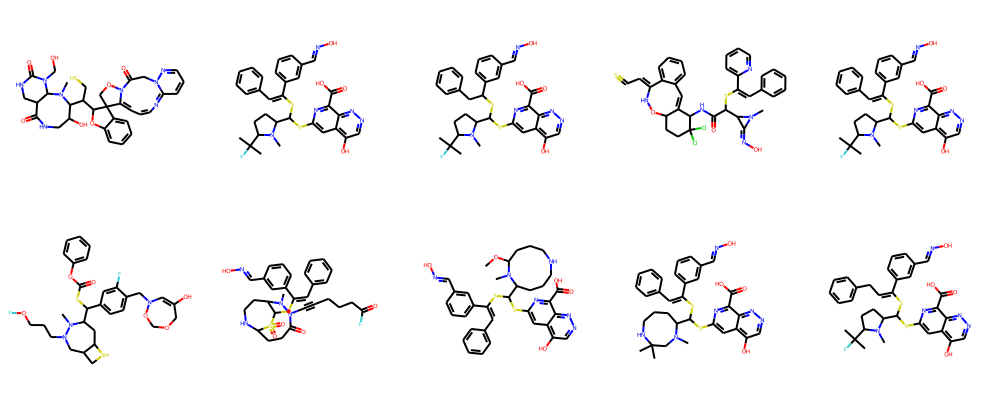

In [ ]:
# generate and plot our generated smiles molecules
latent_seed = latent_space[50:51]
sampling_temp = 0.75
scale = 0.5
quantity = 20
t_mols, t_smiles = generate(latent_seed, sampling_temp, scale, quantity)
Draw.MolsToGridImage(t_mols, molsPerRow=5)

In [ ]:
print(f'Sampled SMILES:\n {t_smiles}')


Sampled SMILES:
 ['CN1C(C(CS)C2Oc3ccccc3C23CON2C(=O)Cn4ncccc4=NC=CC=C32)C(O)CNC(=O)C2CNC(=O)N(CO)C21', 'CN1C(C(SC(=Cc2ccccc2)c2cccc(C=NO)c2)Sc2cc3c(O)cnnc3c(C(=O)O)n2)CCC1C(C)(C)F', 'CN1C(C(SC(Cc2ccccc2)c2cccc(C=NO)c2)Sc2cc3c(O)cnnc3c(C(=O)O)n2)CCC1C(C)(C)F', 'CN1C(C(SC(=Cc2ccccc2)c2ccccn2)C(=O)NC2C3=Cc4ccccc4C(=CC=S)NOC3CCC2(Cl)Cl)C1=NO', 'CN1C(C(SC(=Cc2ccccc2)c2cccc(C=NO)c2)Sc2cc3c(O)cnnc3c(C(=O)O)n2)CCC1C(C)(C)F', 'CN1C(C(SC(=O)Oc2ccccc2)c2ccc(CN3C=C(O)COCO3)c(F)c2)CC2C(CN1CCCOF)C[SH]2', 'CN1C(C(SC(=Cc2ccccc2)c2cccc(C=NO)c2)S(=O)(=O)C2CCC(=O)N1C#CCCCC(F)=O)CCN2', 'CN1C(C(SC(=Cc2ccccc2)c2cccc(C=NO)c2)Sc2cc3c(O)cnnc3c(C(=O)O)n2)CCCNCCCC1OC', 'CN1C(C(SC(=Cc2ccccc2)c2cccc(C=NO)c2)Sc2cc3c(O)cnnc3c(C(=O)O)n2)CCCNC(C)(C)C1', 'CN1C(C(SC(=CCc2ccccc2)c2cccc(C=NO)c2)Sc2cc3c(O)cnnc3c(C(=O)O)n2)CCC1C(C)(C)F']


In [ ]:
# create a for loop to generate molecules based off our sampling dataset's latent space
gen_mols, gen_smiles = [], []
for i in range(latent_space.shape[0] - 1):
  latent_seed = latent_space[i:i+1]
  sampling_temp = rn.uniform(0.75, 1.26)
  scale = 0.75
  quantity = 50
  mols, smiles = generate(latent_seed, sampling_temp, scale, quantity)
  gen_mols.extend(mols)
  gen_smiles.extend(smiles)
  moles, smiles = [], []
print('SMILES generation completed!')

KeyboardInterrupt: ignored

In [ ]:
print(gen_smiles)

['CN1C2CCC1C1CCC3(c4cccc(c4[N+](=O)[O-])CCN3CC3CC[SH](C(=O)O)CC3)N21', 'COC1C2OCC1CCCCNC12COC1C(O)=NC(=C)c2cccc([N+](=O)[O-])c2N=C3C(Cl)C3', 'NC1(CCC2COC3CCCC32Cc2c(O)[nH][n+](=CC3=C2CCC3)cc(F)cn1)[C@H]1OCON1', 'NC1CN(C2=CCC3NC3c3cc(Cc4c[nH]nn4)c(O)cc3C(=O)NC2=O)C1C(C)(Cl)Cl', 'CNC1CC2=CC=CCC1C2-c1c2cc(C(F)(F)F)[nH]c2c(-c2ccc(C(NF)C(C)CO)s2)[nH]1', 'CC1C2CN(C)C(N3CC(Cl)CC3=CC(F)(F)C(=O)CC(=O)C2(N)c2ccccc2)c2ccccc21', 'CC1CC(=O)n2nc(C3CCCC(C)(O)CC(OS(C)(=O)=O)CC3NC=O)CC3(COCc4ccccc43)C(=O)N21', 'CC1CC2N(C)CCCNCCC(NC(=O)COC3CC(C(=O)O)C(=O)N4C3CCC4=O)C(c3ccccc3)N21', 'O=C1C2CCC1C(OC(=S)Sc1cccc3cc(Cl)cc(Cl)c13)C(=Cc1ccnnn1)O2', 'O=C1C2CCC3(C=C(S)OCc4ccccc43)C(=O)NS(=O)(=O)N1c1nnc-2ON1CCC(F)(F)F', 'CC1CCC(N)C2c3ccc(C(O)(Cc4cccc(F)c4)nc3NC=C2C(=O)c2ccc(F)cc2Cl)C1OC(F)F', 'CC1C(C)(C)C2Cc3cc(OS(C)(=O)=O)ccc3c(=O)cc2-c2nccc([n+](c3ccccc3S=O)C2F)C(O)C1=O', 'CNC1(CC=O)C2CC=CCC(C2)NC2C3(C(=O)Nc4ccc(OC)cc4Cl)CC3=C1CCC2N(C)C(=O)Cc1cc(N)cc(C(N)=O)c1-c1cn[n+]1', 'CONC(=O)C1C2CNCN(Nc3ccc(NC(=O)N4CCC5C(

In [ ]:
# save the generated smiles list
outfile = 'generated_smiles_nextgen_v1.csv'
with open(outfile, 'w') as f:
    for smi in gen_smiles:
        f.write(smi + '\n')
print('SMILES saved')

SMILES saved
